In [20]:
! git clone https://github.com/brendenlake/omniglot.git
! cd /content/omniglot/python
! unzip /content/omniglot/python/images_evaluation.zip
! unzip /content/omniglot/python/images_background.zip

! cd ../..
# # setup directory for saving models
! mkdir models

Streaming output truncated to the last 5000 lines.
  inflating: images_background/Malay_(Jawi_-_Arabic)/character28/0583_05.png  
  inflating: images_background/Malay_(Jawi_-_Arabic)/character28/0583_06.png  
  inflating: images_background/Malay_(Jawi_-_Arabic)/character28/0583_07.png  
  inflating: images_background/Malay_(Jawi_-_Arabic)/character28/0583_08.png  
  inflating: images_background/Malay_(Jawi_-_Arabic)/character28/0583_09.png  
  inflating: images_background/Malay_(Jawi_-_Arabic)/character28/0583_10.png  
  inflating: images_background/Malay_(Jawi_-_Arabic)/character28/0583_11.png  
  inflating: images_background/Malay_(Jawi_-_Arabic)/character28/0583_12.png  
  inflating: images_background/Malay_(Jawi_-_Arabic)/character28/0583_13.png  
  inflating: images_background/Malay_(Jawi_-_Arabic)/character28/0583_14.png  
  inflating: images_background/Malay_(Jawi_-_Arabic)/character28/0583_15.png  
  inflating: images_background/Malay_(Jawi_-_Arabic)/character28/0583_16.png  
 

In [2]:
import torch
import pickle
import torchvision
from torchvision import transforms
import torchvision.datasets as dset
from torchvision import transforms
# from mydataset import OmniglotTrain, OmniglotTest
from torch.utils.data import DataLoader
from torch.autograd import Variable
import matplotlib.pyplot as plt

# from model import Siamese
import time
import numpy as np
# import gflags
import sys
from collections import deque
import os

In [9]:
class F:
    CUDA = True
    TRAIN_PATH = "/content/images_background"
    TEST_PATH = "/content/images_evaluation"
    TRAIN_SIZE: int = 16000
    TEST_SIZE: int = 3280
    WAY = 20                    # how much way one-shot learning
    TIMES = 3280                # number of samples to test accuracy
    WORKERS = 2                 # number of dataLoader workers
    BATCH_SIZE = 128
    LR = 0.00006
    show_every = 10
    save_every = 100
    test_every = 100
    max_iter = 5000             # number of iterations before stopping
    model_path = "/content/models/siamese"
    gpu_ids = "0"

In [10]:
F.TRAIN_SIZE, F.TEST_SIZE

(16000, 3280)

In [11]:
data_transforms = transforms.Compose([
    transforms.RandomAffine(15),
    transforms.ToTensor()
])

In [19]:
from torchvision.datasets import Omniglot
from torchvision.transforms import ToTensor

dataset = Omniglot(root='data/', background=True,
                   download=True, transform=data_transforms)

  0%|          | 0/9464212 [00:00<?, ?it/s]

Extracting data/omniglot-py/images_background.zip to data/omniglot-py


In [33]:
# Creating some helper functions
def imshow(img, text=None):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
        
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [13]:
import torch
from torch.utils.data import Dataset, DataLoader
import os
from numpy.random import choice as npc
import numpy as np
import time
import random
import torchvision.datasets as dset
from PIL import Image


class OmniglotTrain(Dataset):
    def __init__(self, dataPath, transform=None):
        super(OmniglotTrain, self).__init__()
        np.random.seed(0)
        # self.dataset = dataset
        self.transform = transform
        self.datas, self.num_classes = self.loadToMem(dataPath)

    def loadToMem(self, dataPath):
        print("begin loading training dataset to memory")
        datas = {}
        agrees = [0, 90, 180, 270]
        idx = 0
        for agree in agrees:
            for alphaPath in os.listdir(dataPath):
                for charPath in os.listdir(os.path.join(dataPath, alphaPath)):
                    datas[idx] = []
                    for samplePath in os.listdir(os.path.join(dataPath, alphaPath, charPath)):
                        filePath = os.path.join(dataPath, alphaPath, charPath, samplePath)
                        datas[idx].append(Image.open(filePath).rotate(agree).convert('L'))
                    idx += 1
        print("finish loading training dataset to memory")
        return datas, idx

    def __len__(self):
        return  21000000

    def __getitem__(self, index):
        # image1 = random.choice(self.dataset.imgs)
        label = None
        img1 = None
        img2 = None
        # get image from same class
        if index % 2 == 1:
            label = 1.0
            idx1 = random.randint(0, self.num_classes - 1)
            image1 = random.choice(self.datas[idx1])
            image2 = random.choice(self.datas[idx1])
        # get image from different class
        else:
            label = 0.0
            idx1 = random.randint(0, self.num_classes - 1)
            idx2 = random.randint(0, self.num_classes - 1)
            while idx1 == idx2:
                idx2 = random.randint(0, self.num_classes - 1)
            image1 = random.choice(self.datas[idx1])
            image2 = random.choice(self.datas[idx2])

        if self.transform:
            image1 = self.transform(image1)
            image2 = self.transform(image2)
        return image1, image2, torch.from_numpy(np.array([label], dtype=np.float32))


In [14]:
class OmniglotTest(Dataset):

    def __init__(self, dataPath, transform=None, times=200, way=20):
        np.random.seed(1)
        super(OmniglotTest, self).__init__()
        self.transform = transform
        self.times = times
        self.way = way
        self.img1 = None
        self.c1 = None
        self.datas, self.num_classes = self.loadToMem(dataPath)

    def loadToMem(self, dataPath):
        print("begin loading test dataset to memory")
        datas = {}
        idx = 0
        for alphaPath in os.listdir(dataPath):
            for charPath in os.listdir(os.path.join(dataPath, alphaPath)):
                datas[idx] = []
                for samplePath in os.listdir(os.path.join(dataPath, alphaPath, charPath)):
                    filePath = os.path.join(dataPath, alphaPath, charPath, samplePath)
                    datas[idx].append(Image.open(filePath).convert('L'))
                idx += 1
        print("finish loading test dataset to memory")
        return datas, idx

    def __len__(self):
        return self.times * self.way

    def __getitem__(self, index):
        idx = index % self.way
        label = None
        img1 = self.img1
        img2 = None
        # generate image pair from same class
        if idx == 0:
            self.c1 = random.randint(0, self.num_classes - 1)
            self.img1 = random.choice(self.datas[self.c1])
            img2 = random.choice(self.datas[self.c1])
        # generate image pair from different class
        else:
            c2 = random.randint(0, self.num_classes - 1)
            while self.c1 == c2:
                c2 = random.randint(0, self.num_classes - 1)
            img2 = random.choice(self.datas[c2])

        if self.transform:
            img1 = self.transform(self.img1)
            img2 = self.transform(img2)
        return img1, img2

In [15]:
# from torch.utils.data import random_split
# print(len(dataset))
# train_ds, test_ds = random_split(dataset,
#                                  [F.TRAIN_SIZE, F.TEST_SIZE])
# len(train_ds), len(test_ds)

In [16]:
os.environ["CUDA_VISIBLE_DEVICES"] = F.gpu_ids
print("use gpu:", F.gpu_ids, "to train.")

use gpu: 0 to train.


In [21]:
train_ds = OmniglotTrain(F.TRAIN_PATH, transform=data_transforms)

begin loading training dataset to memory
finish loading training dataset to memory


In [22]:
from torchvision.transforms.transforms import ToTensor
test_ds = OmniglotTest(F.TEST_PATH, transform=ToTensor(),
                       times=F.TIMES, way=F.WAY)

begin loading test dataset to memory
finish loading test dataset to memory


In [23]:
train_dl = DataLoader(train_ds, F.BATCH_SIZE, shuffle=True,
                      num_workers=F.WORKERS, pin_memory=True)
# test_dl = DataLoader(test_ds, F.BATCH_SIZE,
#                      num_workers=F.WORKERS, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size=F.WAY,
                     shuffle=False, num_workers=1)

In [24]:
import torch
import torch.nn as nn
# import torch.nn.functional as F


class Siamese(nn.Module):
    def __init__(self):
        super(Siamese, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, 10),  # 64@96*96
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 64@48*48
            nn.Conv2d(64, 128, 7),
            nn.ReLU(),    # 128@42*42
            nn.MaxPool2d(2),   # 128@21*21
            nn.Conv2d(128, 128, 4),
            nn.ReLU(), # 128@18*18
            nn.MaxPool2d(2), # 128@9*9
            nn.Conv2d(128, 256, 4),
            nn.ReLU(),   # 256@6*6
        )
        self.liner = nn.Sequential(nn.Linear(9216, 4096), nn.Sigmoid())
        self.out = nn.Linear(4096, 1)

    def forward_one(self, x):
        x = self.conv(x)
        x = x.view(x.size()[0], -1)
        x = self.liner(x)
        return x

    def forward(self, x1, x2):
        out1 = self.forward_one(x1)
        out2 = self.forward_one(x2)
        dis = torch.abs(out1 - out2)
        out = self.out(dis)
        #  return self.sigmoid(out)
        return out

In [25]:
net = Siamese()
print(net)
# print(list(net.parameters()))

Siamese(
  (conv): Sequential(
    (0): Conv2d(1, 64, kernel_size=(10, 10), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(7, 7), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 128, kernel_size=(4, 4), stride=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1))
    (10): ReLU()
  )
  (liner): Sequential(
    (0): Linear(in_features=9216, out_features=4096, bias=True)
    (1): Sigmoid()
  )
  (out): Linear(in_features=4096, out_features=1, bias=True)
)


In [26]:
loss_fn = torch.nn.BCEWithLogitsLoss(size_average=True)
net = Siamese()

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [27]:
if F.CUDA:
    net.cuda()

In [28]:
net.train()

Siamese(
  (conv): Sequential(
    (0): Conv2d(1, 64, kernel_size=(10, 10), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(7, 7), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 128, kernel_size=(4, 4), stride=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1))
    (10): ReLU()
  )
  (liner): Sequential(
    (0): Linear(in_features=9216, out_features=4096, bias=True)
    (1): Sigmoid()
  )
  (out): Linear(in_features=4096, out_features=1, bias=True)
)

In [29]:
optimizer = torch.optim.Adam(net.parameters(),lr = F.LR)
optimizer.zero_grad()

In [35]:
train_loss = []
loss_val = 0
time_start = time.time()
queue = deque(maxlen=20)

counter = []
loss_history = []

[10]	loss:	0.40929	time lapsed:	4.55 s
[20]	loss:	0.38274	time lapsed:	1.57 s
[30]	loss:	0.40713	time lapsed:	1.72 s
[40]	loss:	0.41587	time lapsed:	1.58 s
[50]	loss:	0.40029	time lapsed:	1.57 s
[60]	loss:	0.39348	time lapsed:	1.57 s
[70]	loss:	0.40699	time lapsed:	1.57 s
[80]	loss:	0.38711	time lapsed:	1.57 s
[90]	loss:	0.39281	time lapsed:	1.58 s
[100]	loss:	0.38790	time lapsed:	1.57 s
**********************************************************************
[100]	Test set	correct:	1084	error:	2196	precision:	0.330488
**********************************************************************
[110]	loss:	0.39061	time lapsed:	42.54 s
[120]	loss:	0.38268	time lapsed:	1.57 s
[130]	loss:	0.38192	time lapsed:	1.57 s
[140]	loss:	0.38171	time lapsed:	1.57 s
[150]	loss:	0.38739	time lapsed:	1.57 s
[160]	loss:	0.39824	time lapsed:	1.57 s
[170]	loss:	0.38177	time lapsed:	1.57 s
[180]	loss:	0.37625	time lapsed:	1.57 s
[190]	loss:	0.37484	time lapsed:	1.57 s
[200]	loss:	0.37760	time lapsed:	1.57 s
*****

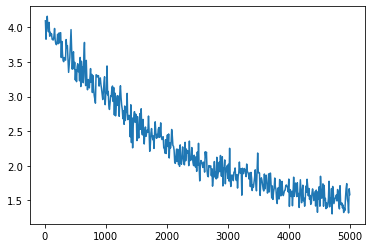

In [36]:
for batch_id, (img1, img2, label) in enumerate(train_dl, 1):
    if batch_id > F.max_iter:
        break
    if F.CUDA:
        img1, img2, label = Variable(img1.cuda()), Variable(img2.cuda()), Variable(label.cuda())
    else:
        img1, img2, label = Variable(img1), Variable(img2), Variable(label)
    optimizer.zero_grad()
    output = net.forward(img1, img2)
    loss = loss_fn(output, label)
    loss_val += loss.item()
    loss.backward()
    optimizer.step()
    if batch_id % F.show_every == 0 :
        print('[%d]\tloss:\t%.5f\ttime lapsed:\t%.2f s'%(batch_id, loss_val / F.show_every, time.time() - time_start))
        counter.append(batch_id)
        loss_history.append(loss_val)
        loss_val = 0
        time_start = time.time()
    if batch_id % F.save_every == 0:
        torch.save(net.state_dict(), F.model_path + '/model-inter-' + str(batch_id+1) + ".pt")
    if batch_id % F.test_every == 0:
        right, error = 0, 0
        for idx, tests in enumerate(test_dl):
            test1 = tests[0]
            test2 = tests[1]
            if F.CUDA:
                test1, test2 = test1.cuda(), test2.cuda()
            test1, test2 = Variable(test1), Variable(test2)
            output = net.forward(test1, test2).data.cpu().numpy()
            pred = np.argmax(output)
            if pred == 0:
                right += 1
            else: error += 1
        print('*'*70)
        print('[%d]\tTest set\tcorrect:\t%d\terror:\t%d\tprecision:\t%f'%(batch_id, right, error, right*1.0/(right+error)))
        print('*'*70)
        queue.append(right*1.0/(right+error))
    train_loss.append(loss_val)
    # learning_rate = learning_rate * 0.95

show_plot(counter, loss_history)

In [ ]:
with open('train_loss', 'wb') as f:
    pickle.dump(train_loss, f)

acc = 0.0
for d in queue:
    acc += d
print("#"*70)
print("final accuracy: ", acc/20)